# LSTM base net Implemented by Keras

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import keras

import ipdb
import dan_utils

In [4]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [73]:
flow_df = pd.read_csv('../data/revised_data/flow_b_revised.csv')
flow = flow_df.to_numpy()

In [74]:
flow.shape

(40, 4464)

# Data assembling

In [75]:
# # sliding window
# window_size = 10
# pred_size = 20
# train_X = np.zeros([flow.shape[0] - window_size - pred_size + 1, window_size, flow.shape[1]])
# train_y = np.zeros(train_X.shape[0], pred_size)

# for i in range(window_size):
#     train_X[:, i, :] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]
#     # train_y[:, i] += flow_df.shift(window_size - i - 1).iloc[window_size - 1:, :]


In [81]:
pred_samp = 10
def sliding_window(data, window_size, prop):
    
#     data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[1] - window_size - pred_samp):
        data_out.append(data[:, i : i + window_size])
        # to predict the next [window size] flows
        label_out.append(data[:, i + window_size + 1: i + window_size + 1 + pred_samp])
    data_out = np.array(data_out)
    label_out = np.array(label_out)
#     ipdb.set_trace()
    train_data_out = data_out[:int(data_out.shape[0]*prop), :]
    train_label_out = label_out[:int(data_out.shape[0]*prop)]
    val_data_out = data_out[int(data_out.shape[0]*prop):, :]
    val_label_out = label_out[int(data_out.shape[0]*prop):]
    
    train_data_out = np.transpose(train_data_out, [0, 2, 1])
    train_label_out = np.transpose(train_label_out, [0, 2, 1])
    val_data_out = np.transpose(val_data_out, [0, 2, 1])
    val_label_out = np.transpose(val_label_out, [0, 2, 1])
    
    return train_data_out, train_label_out, val_data_out, val_label_out


In [82]:
window_size = 10

train_X, train_y, test_X, test_y = sliding_window(flow, window_size, 0.3)

In [83]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(1333, 10, 40)
(1333, 10, 40)
(3111, 10, 40)
(3111, 10, 40)


# LSTM network (base)

In [92]:
# data at the position of "number of detectors" are the same
assert train_X.shape[2] == train_y.shape[2]
assert train_X.shape[2] == test_X.shape[2]
assert train_X.shape[2] == test_y.shape[2]
num_det = flow.shape[0]

hid_dim = 40

In [93]:
train_X.shape

(1333, 10, 40)

In [95]:
model = keras.models.Sequential()
# out shape: [window_size, hid_dim]
model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
# model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
# model.add(keras.layers.LSTM(units=hid_dim, return_sequences=True))
# model.add(keras.layers.Dense(train_y.shape[1]))

In [100]:
import random
inputs = np.random.random([32, 10, 8])
lstm = keras.layers.LSTM(4)
output = lstm(inputs)

ValueError: Layer lstm_14 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[[0.88030791, 0.51262149, 0.52128777, ..., 0.78178317,
         0.41417353, 0.83352435],
        [0.13723431, 0.37403893, 0.5186441 , ..., 0.22821726,
         0.47152955, 0.09163615],
        [0.03816948, 0.12070519, 0.65060235, ..., 0.79768715,
         0.1274739 , 0.36396916],
        ...,
        [0.89317474, 0.10013459, 0.1740693 , ..., 0.51843663,
         0.91846068, 0.24117138],
        [0.05809041, 0.81269529, 0.50632583, ..., 0.53405403,
         0.05473266, 0.71804608],
        [0.54848922, 0.50206244, 0.81055937, ..., 0.54331645,
         0.99670131, 0.23823433]],

       [[0.38438537, 0.26921556, 0.30095753, ..., 0.22333556,
         0.92905893, 0.76125039],
        [0.53163829, 0.30373591, 0.37476666, ..., 0.7223177 ,
         0.03954259, 0.67923907],
        [0.0898354 , 0.77202695, 0.94240221, ..., 0.03366296,
         0.69063865, 0.35303704],
        ...,
        [0.35023916, 0.82616219, 0.23150652, ..., 0.59904368,
         0.68877365, 0.27853519],
        [0.3601319 , 0.65278994, 0.30955888, ..., 0.68515001,
         0.83624971, 0.90821972],
        [0.09424146, 0.06017159, 0.89375064, ..., 0.15004055,
         0.86975951, 0.17626877]],

       [[0.73559719, 0.5204979 , 0.72545053, ..., 0.70558969,
         0.84135652, 0.51014258],
        [0.70658469, 0.07097722, 0.25429799, ..., 0.59436433,
         0.94122056, 0.44243535],
        [0.80871592, 0.23380236, 0.84975695, ..., 0.97735878,
         0.99173491, 0.32666507],
        ...,
        [0.96682587, 0.77982252, 0.47449778, ..., 0.67642619,
         0.62477433, 0.21984437],
        [0.35965092, 0.37053574, 0.11056668, ..., 0.83589495,
         0.95434394, 0.19707768],
        [0.77712002, 0.83877034, 0.70111481, ..., 0.46346529,
         0.56085205, 0.03906908]],

       ...,

       [[0.97213964, 0.39077984, 0.7694814 , ..., 0.24276055,
         0.75052548, 0.01545967],
        [0.28663591, 0.02760832, 0.49158816, ..., 0.90109911,
         0.22511933, 0.34328819],
        [0.80609753, 0.74506979, 0.82097504, ..., 0.77643875,
         0.48271421, 0.74608359],
        ...,
        [0.43227754, 0.19408899, 0.48257152, ..., 0.29046498,
         0.33461378, 0.65865802],
        [0.64128053, 0.86064003, 0.82950512, ..., 0.03610174,
         0.6870064 , 0.11776313],
        [0.81143269, 0.30697862, 0.64846619, ..., 0.79158291,
         0.71591473, 0.60274785]],

       [[0.49364648, 0.00327626, 0.19663591, ..., 0.82199748,
         0.89549391, 0.59209534],
        [0.01386602, 0.60101263, 0.20977983, ..., 0.54751902,
         0.56688504, 0.10874199],
        [0.4546646 , 0.0688502 , 0.47787752, ..., 0.25611473,
         0.2976083 , 0.86969024],
        ...,
        [0.3603305 , 0.66982512, 0.60883769, ..., 0.13598659,
         0.81410572, 0.30641923],
        [0.65141604, 0.05065781, 0.41772719, ..., 0.09113175,
         0.0847839 , 0.07127874],
        [0.54827728, 0.94499609, 0.08279748, ..., 0.17758738,
         0.2527796 , 0.09386668]],

       [[0.43636899, 0.06116853, 0.49920372, ..., 0.85072358,
         0.58787246, 0.1464442 ],
        [0.20700873, 0.14483049, 0.80629753, ..., 0.5348726 ,
         0.20481343, 0.02892652],
        [0.29231512, 0.5714102 , 0.57267802, ..., 0.81873052,
         0.21477776, 0.01150424],
        ...,
        [0.24380048, 0.33590854, 0.7024572 , ..., 0.58980294,
         0.62625386, 0.78872141],
        [0.23147637, 0.96095968, 0.35595186, ..., 0.0758908 ,
         0.79234768, 0.39851623],
        [0.29269959, 0.87772198, 0.48990011, ..., 0.91630882,
         0.09513723, 0.46874075]]])]. All inputs to the layer should be tensors.

In [96]:
model(train_X)

ValueError: Layer sequential_6 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[[260.        ,  72.        ,  81.        , ..., 365.        ,
         221.4       , 221.4       ],
        [250.        ,  36.        ,  84.        , ..., 294.        ,
         209.        , 209.        ],
        [231.        ,  52.        ,  62.51851852, ..., 279.        ,
         150.637037  , 150.637037  ],
        ...,
        [142.        ,  46.        ,  60.        , ..., 177.        ,
         107.6666667 , 107.6666667 ],
        [178.        ,  48.        ,  63.19230769, ..., 216.1333333 ,
         114.4615385 , 114.4615385 ],
        [121.        ,  50.        ,  63.        , ..., 181.        ,
         116.        , 116.        ]],

       [[250.        ,  36.        ,  84.        , ..., 294.        ,
         209.        , 209.        ],
        [231.        ,  52.        ,  62.51851852, ..., 279.        ,
         150.637037  , 150.637037  ],
        [140.        ,  47.76666667,  67.81481481, ..., 255.        ,
         164.4166667 , 164.4166667 ],
        ...,
        [178.        ,  48.        ,  63.19230769, ..., 216.1333333 ,
         114.4615385 , 114.4615385 ],
        [121.        ,  50.        ,  63.        , ..., 181.        ,
         116.        , 116.        ],
        [120.7931034 ,  38.        ,  53.        , ..., 160.        ,
         100.        , 100.        ]],

       [[231.        ,  52.        ,  62.51851852, ..., 279.        ,
         150.637037  , 150.637037  ],
        [140.        ,  47.76666667,  67.81481481, ..., 255.        ,
         164.4166667 , 164.4166667 ],
        [230.        ,  71.75862069,  56.10344828, ..., 258.6206897 ,
         111.8571429 , 111.8571429 ],
        ...,
        [121.        ,  50.        ,  63.        , ..., 181.        ,
         116.        , 116.        ],
        [120.7931034 ,  38.        ,  53.        , ..., 160.        ,
         100.        , 100.        ],
        [103.7791005 ,  43.33333333,  95.8       , ..., 151.        ,
          74.4       ,  74.4       ]],

       ...,

       [[276.        ,  51.        ,  79.82608696, ..., 325.5652174 ,
         193.        , 193.        ],
        [272.1428571 ,  46.31034483,  98.45833333, ..., 363.        ,
         371.15      , 371.15      ],
        [316.        ,  52.14285714, 103.2916667 , ..., 394.        ,
         363.        , 363.        ],
        ...,
        [565.        ,  69.        , 219.9230769 , ..., 821.        ,
         553.3913043 , 553.3913043 ],
        [500.        ,  98.        , 222.        , ..., 747.        ,
         619.        , 619.        ],
        [546.        , 111.25      , 273.6666667 , ..., 740.        ,
         579.4166667 , 579.4166667 ]],

       [[272.1428571 ,  46.31034483,  98.45833333, ..., 363.        ,
         371.15      , 371.15      ],
        [316.        ,  52.14285714, 103.2916667 , ..., 394.        ,
         363.        , 363.        ],
        [372.        ,  85.        , 139.0869565 , ..., 476.        ,
         413.2857143 , 413.2857143 ],
        ...,
        [500.        ,  98.        , 222.        , ..., 747.        ,
         619.        , 619.        ],
        [546.        , 111.25      , 273.6666667 , ..., 740.        ,
         579.4166667 , 579.4166667 ],
        [564.        ,  57.        , 220.        , ..., 723.5185185 ,
         626.875     , 626.875     ]],

       [[316.        ,  52.14285714, 103.2916667 , ..., 394.        ,
         363.        , 363.        ],
        [372.        ,  85.        , 139.0869565 , ..., 476.        ,
         413.2857143 , 413.2857143 ],
        [455.        ,  60.43333333, 150.8       , ..., 558.9166667 ,
         550.2592593 , 550.2592593 ],
        ...,
        [546.        , 111.25      , 273.6666667 , ..., 740.        ,
         579.4166667 , 579.4166667 ],
        [564.        ,  57.        , 220.        , ..., 723.5185185 ,
         626.875     , 626.875     ],
        [514.        ,  63.92857143, 284.2083333 , ..., 587.        ,
         644.5185185 , 644.5185185 ]]])]. All inputs to the layer should be tensors.

# Training on target data

In [43]:
inp_dim = tar_flow.shape[0]
out_dim = tar_flow.shape[0]
hid_dim = tar_flow.shape[0]
layers = 3

In [44]:
traff_node_base = traffic_base_net(inp_dim, out_dim, hid_dim, layers).to(device)

loss_func = nn.MSELoss()
val_loss_set = []
train_loss_set = []

#summary(traff_node_dannet, input_size=(batch_size, window_size), device=device)

In [47]:
optimizer = optim.SGD(traff_node_base.parameters(), lr=0.01)

In [48]:
traff_node_base.train()

epochs = 1001

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(src_train_loader)):
        try:
            tar_data, tar_label = tar_iter.next()
        except:
            tar_iter = iter(tar_train_loader)
            tar_data, tar_label = tar_iter.next()
        
        tar_out = traff_node_base(tar_data)
        #ipdb.set_trace()
        loss = loss_func(tar_out, tar_label)  # target dataset loss

        val_out = traff_node_base(tar_val_data)
        val_loss = loss_func(val_out, tar_val_label)
        #ipdb.set_trace()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i success, val loss:%.5f, train loss:%.5f'%(e, val_loss.cpu().detach().numpy(), loss.cpu().detach().numpy()))

Epoch 0 success, val loss:190640.25000, train loss:206049.59375
Epoch 50 success, val loss:83848.58594, train loss:93288.41406
Epoch 100 success, val loss:49549.83203, train loss:55334.06250
Epoch 150 success, val loss:38917.11719, train loss:42798.39844
Epoch 200 success, val loss:35853.73047, train loss:38533.00781
Epoch 250 success, val loss:35115.41797, train loss:36971.77344
Epoch 300 success, val loss:35035.01953, train loss:36624.78516
Epoch 350 success, val loss:35104.50781, train loss:36504.45703
Epoch 400 success, val loss:35183.89062, train loss:36468.76172


KeyboardInterrupt: 

# Visualization

In [49]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

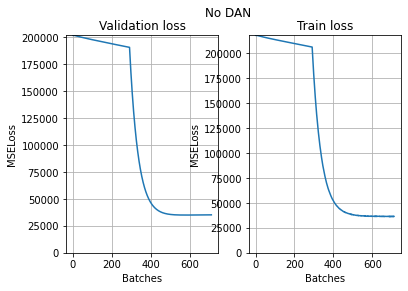

In [50]:
plot_loss(val_loss_set, train_loss_set, 'No DAN')

In [51]:
val_out.shape

torch.Size([894, 10, 90])

Text(0.5, 1.0, 'Target dataset')

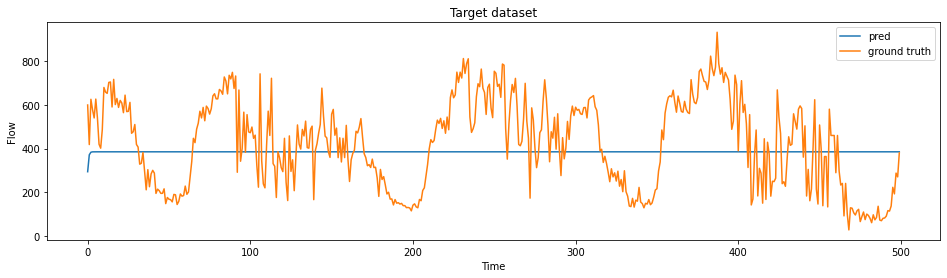

In [52]:
plt.figure(figsize=[16,4])
plt.plot(val_out[:500, -3, 0].cpu().detach().numpy(), label='pred')
plt.plot(tar_val_label[:500, -3, 0].cpu().detach().numpy(), label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 15 min
plt.ylabel('Flow')
plt.title('Target dataset')

# Evaluation

In [53]:
def denorm_data(vec, min_val, max_val):
    return vec*(max_val - min_val) + min_val

In [54]:
# traff_node_dannet = torch.load('./model/traff_node_dannet.pth')
traff_node_base.eval()

val_out = traff_node_base(tar_val_data).cpu().detach().numpy()
val_out_denormed = denorm_data(val_out, tar_min, tar_max)
tar_val_label_denormed = denorm_data(tar_val_label.cpu().detach().numpy(), tar_min, tar_max)
i=0
j=1
m=.05
mape=dan_utils.mape_loss_func(val_out_denormed[:, i, j], tar_val_label_denormed[:, i, j], m)
nrmse=dan_utils.nrmse_loss_func(val_out_denormed, tar_val_label_denormed, m)
print('MAPE: %.5f'%mape)
print('SMAPE: %.5f'%dan_utils.smape_loss_func(val_out_denormed, tar_val_label_denormed, m))
print('MAE: %.5f'%dan_utils.mae_loss_func(val_out_denormed, tar_val_label_denormed, m))
print('NRMSE: %.5f'%nrmse)


NameError: name 'tar_min' is not defined

In [84]:
torch.save(traff_node_base.state_dict(), '../model/base_LSTM_mape=%.5f_nrmse=%.5f.h5'%(mape, nrmse))
torch.cuda.empty_cache()

In [55]:
mape_set = []
for i in range(3):
    for j in range(30):
        plt.figure()
        plt.plot(val_out_denormed[:, i, j])
        plt.plot(tar_val_label_denormed[:, i, j])
        mape = mape_loss_func(val_out_denormed[:, i, j], tar_val_label_denormed[:, i, j])
        mape_set.append(mape)
        plt.title('%i%i,mape=%.3f'%(i, j, mape))

NameError: name 'val_out_denormed' is not defined

<Figure size 432x288 with 0 Axes>